In [1]:
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pprint

In [2]:
songs = pd.read_csv("songsWithPopularity.csv",sep=",")
songsWithValidPopularity = songs[songs["Spotify_Popularity"] > 0]
songsWithValidPopularity.shape

(3161, 5)

# Baseline Model

Applying regression between the variables C, M and y.
1. C - Current Popularity
2. M - Billboard Rank in the year of its appearance on Billboard
3. y - Number of years elapsed since its appearnce

In [3]:
def getTrainTestPermuteForDataframeIndex(df, trainFraction, testFraction):
    dfSize = len(df.index)
    perm = np.random.permutation(df.index)
    trainEnd = int(trainFraction * dfSize)
    validateEnd = int(testFraction * dfSize) + trainEnd
    return perm[:trainEnd], perm[trainEnd:validateEnd]

In [4]:
x1 = songsWithValidPopularity['Rank']
x2 = 2018 - songsWithValidPopularity['year']
y = songsWithValidPopularity['Spotify_Popularity']
df = pd.DataFrame({"Year": x2.values, 
                   "Spotify_Popularity": y.values, 
                   "Original_Year": songsWithValidPopularity['year'].values, 
                   "Rank":songsWithValidPopularity["Rank"].values, 
                   "Title": songsWithValidPopularity["Title"].values, 
                   "Artist": songsWithValidPopularity["Artist"].values})

permutedTrainIndexArr, permutedTestIndexArr = getTrainTestPermuteForDataframeIndex(df, 0.8, 0.2)

trainDf = df.iloc[permutedTrainIndexArr]
testDf = df.iloc[permutedTestIndexArr]

trainX = pd.DataFrame({"Rank": trainDf["Rank"].values, "Year": trainDf["Year"].values})
trainY = trainDf["Spotify_Popularity"].values.reshape(-1,1)

testX = pd.DataFrame({"Rank": testDf["Rank"].values, "Year": testDf["Year"].values})
testY = testDf["Spotify_Popularity"].values.reshape(-1,1)
df.head()

,Year,Spotify_Popularity,Original_Year,Rank,Title,Artist
0,58,52,1960,1,Theme From “A Summer Place”,Percy Faith
1,58,45,1960,13,Greenfields,Brothers Four
2,58,61,1960,15,El Paso,Marty Robbins
3,58,29,1960,21,Where Or When,Dion and The Belmonts
4,58,8,1960,24,Why,Frankie Avalon


# Assuming Linear Relationship Between C, M, y

C = beta0 * M + beta1 * y + beta2

In [48]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

def linearModel(trainX, trainY, testX, testY):
    regression = linear_model.Ridge()
    model = regression.fit(trainX, trainY)
    print(regression.coef_, regression.intercept_)
    trainMse = mean_squared_error(trainY, regression.predict(trainX))
    print("Linear Regression: Train MSE: ", trainMse)
    
    predY = regression.predict(testX)
    #print(predY)
    testMse = mean_squared_error(testY, predY)
    print("Linear Regression: Test MSE: ", testMse)
    return predY

t = linearModel(trainX, trainY, testX, testY)

[[-4.37596411 -0.47476298]] [81.87181553]
Linear Regression: Train MSE:  190.3922941978174
Linear Regression: Test MSE:  188.51461056100788


In [50]:
def calculateCP1(M, y):
    CP = -4.37*M - 0.474*y + 81.87
    return CP

predictedCP = calculateCP1(90, 58)
predictedCP

-338.922

# Why linear relationship is a bad choice?

1. It predicts negative values for the rank. It's harder to restrict the predicted popularity values between 0 to 100

# Assuming Exponential Relationship Between C, M, y

C = M^beta0 ** e^(beta1 * y + beta2)

In [6]:
trX = trainX
tstX = testX
trX["Rank"] = np.log(trX["Rank"])
tstX["Rank"] = np.log(tstX["Rank"])
trY = np.log(trainY)
tstY = np.log(testY)
predY = linearModel(trainX, trY, testX, tstY)

[[-0.0968608  -0.01167705]] [4.57521378]
Linear Regression: Train MSE:  0.17957664620212568
Linear Regression: Test MSE:  0.20750925021491343


In [7]:
def calculateCP(M, y):
    K = np.exp(4.57)
    CP = (pow(M, -1*0.1)* np.exp(-0.01*y) * K)
    return CP

predictedCP = calculateCP(90, 58)
predictedCP

34.46757520483496

# Baseline Model Analysis

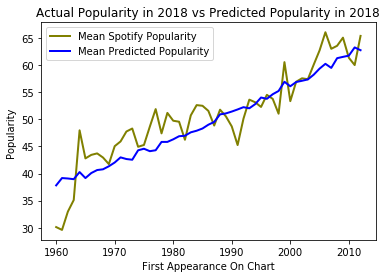

In [10]:
import matplotlib.pyplot as plt
df["Predicted_Popularity"] = df.apply(lambda x: calculateCP(float(x["Rank"]), x["Year"]), axis=1)

df["Performance"] = df["Spotify_Popularity"]/df["Predicted_Popularity"]
groupedDf = df.groupby("Original_Year").mean().reset_index()

plt.title("Actual Popularity in 2018 vs Predicted Popularity in 2018")
plt.plot('Original_Year', 'Spotify_Popularity', data=groupedDf, color='olive', linewidth=2, label="Mean Spotify Popularity")
plt.plot('Original_Year', 'Predicted_Popularity', data=groupedDf, color='blue', linewidth=2, label="Mean Predicted Popularity")
plt.xlabel("First Appearance On Chart")
plt.ylabel("Popularity ")
plt.legend()

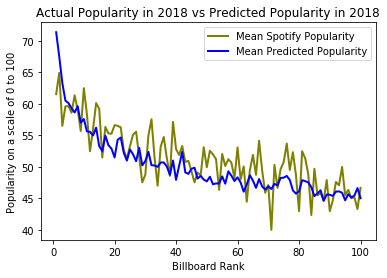

In [11]:
groupedDf = df.groupby("Rank").mean().reset_index()

plt.title("Actual Popularity in 2018 vs Predicted Popularity in 2018")
plt.plot('Rank', 'Spotify_Popularity', data=groupedDf, color='olive', linewidth=2, label="Mean Spotify Popularity")
plt.plot('Rank', 'Predicted_Popularity', data=groupedDf, color='blue', linewidth=2, label="Mean Predicted Popularity")
plt.ylabel("Popularity on a scale of 0 to 100")
plt.xlabel("Billboard Rank")
plt.legend()


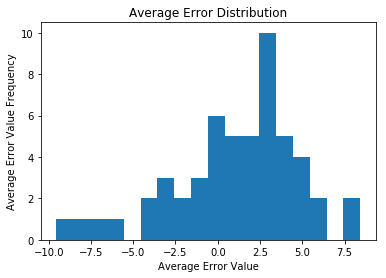

In [40]:
df["Average_Error"] = df["Spotify_Popularity"] - df["Predicted_Popularity"]
groupedDf = df.groupby("Original_Year").mean().reset_index()

plt.title("Average Error Distribution")
plt.hist(groupedDf['Average_Error'], bins=np.arange(groupedDf['Average_Error'].min(), groupedDf['Average_Error'].max()+1))
plt.xlabel("Average Error Value")
plt.ylabel("Average Error Value Frequency")
plt.show()


Most of the error values lie between - 5 to + 5. 
Our model predicts the spotify popularity from rank and number of years with a difference of +/-5.

# Over Performing Songs 

In [34]:
newDf = df.sort_values(by=['Performance'], ascending=False).head(100)
newDf = newDf[['Title','Artist', 'Original_Year', 'Rank', 'Spotify_Popularity', 'Predicted_Popularity', 'Performance']]
newDf = newDf[newDf['Original_Year'] <= 1980]
newDf.head(10)

,Title,Artist,Original_Year,Rank,Spotify_Popularity,Predicted_Popularity,Performance
425,Come Together,Beatles,1969,85,77,37.929716,2.030071
375,I Say A Little Prayer,Aretha Franklin,1968,93,74,37.216047,1.988390
164,You Really Got Me,Kinks,1964,78,70,36.391278,1.923538
284,Brown Eyed Girl,Van Morrison,1967,35,78,40.628313,1.919843
153,Twist And Shout,Beatles,1964,40,74,38.904583,1.902090
126,Ring Of Fire,Johnny Cash,1963,80,68,35.938076,1.892144
526,Riders On The Storm,Doors,1971,99,72,38.110431,1.889247
516,Wild World,Cat Stevens,1971,73,74,39.289372,1.883461
167,I Saw Her Standing There,Beatles,1964,95,67,35.680785,1.877761
48,Take Five,Dave Brubeck,1961,95,65,34.626259,1.877188


# Under Performing Songs

In [35]:
newDf = df.sort_values(by=['Performance'], ascending=True).head(100)
newDf = newDf[['Title','Artist', 'Original_Year', 'Rank', 'Spotify_Popularity', 'Predicted_Popularity', 'Performance']]
newDf = newDf[newDf['Original_Year'] <= 1980]
newDf.head(10)

,Title,Artist,Original_Year,Rank,Spotify_Popularity,Predicted_Popularity,Performance
517,Watching Scotty Grow,Bobby Goldsboro,1971,78,1,39.029943,0.025621
35,Apache,Jørgen Ingmann,1961,35,1,38.262304,0.026135
79,Snap Your Fingers,Joe Henderson,1962,66,1,36.271580,0.027570
20,Poetry In Motion,Johnny Tillotson,1960,87,1,34.584624,0.028915
428,Oh Happy Day,Edwin Hawkins Singers,1969,93,2,37.590075,0.053206
86,Soul Twist,King Curtis,1962,92,2,35.086665,0.057002
87,Where Have All The Flowers Gone,Kingston Trio,1962,95,2,34.974258,0.057185
34,I Like It Like That,Chris Kenner,1961,34,3,38.373378,0.078179
10,Night,Jackie Wilson,1960,34,3,37.991557,0.078965
40,Walk Right Back,Everly Brothers,1961,57,3,36.441013,0.082325


# Improved Model

In this model, we plan to incorporate 1 additional feature - Artist Popularity
We believe that Artist Popularity is an important feature which affects any songs current popularity.